In [1]:
import jtap_mice
jtap_mice.set_jaxcache()
from jtap_mice.inference import run_jtap, run_parallel_jtap, JTAPMiceData
from jtap_mice.viz import rerun_jtap_stimulus, animate_jtap_mice_predictions, jtap_plot_lr_lines, plot_proposal_direction_outlier_pdf, draw_stimulus_image
from jtap_mice.utils import load_left_right_stimulus, JTAPMiceStimulus, ChexModelInput, d2r, i_, f_, slice_pt, init_step_concat, discrete_obs_to_rgb, stack_pytrees, concat_pytrees
from jtap_mice.evaluation import jtap_compute_beliefs, JTAPMice_Beliefs

import time
import rerun as rr
import genjax
from genjax import gen, ChoiceMapBuilder as C
import jax
import jax.numpy as jnp
from jax.debug import print as jprint
import numpy as np
from tqdm import tqdm
import jax.tree_util as jtu
from functools import partial
from matplotlib import pyplot as plt
from typing import List, Dict, Any, Tuple, NamedTuple

PIXEL_DENSITY = 10
SKIP_T = 4

In [2]:
LR_CONFIG= 'lr_v1'
LR_TRIAL = 1

stimulus_path = f'{LR_CONFIG}.json'

jtap_stimulus = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY, skip_t = SKIP_T, trial_number = LR_TRIAL, inject_occlusion = [[3.4, 2.7]])
# jtap_stimulus = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY, skip_t = SKIP_T, trial_number = LR_TRIAL, inject_occlusion = None)

In [ ]:
rerun_jtap_stimulus(discrete_obs = jtap_stimulus.discrete_obs, stimulus_name = "rg_stim1_discrete")

In [3]:
# Parameters based on default values in ChexModelInput @datastrucs.py

model_direction_flip_prob = 0.025
simulation_direction_flip_prob = 0.005
proposal_direction_flip_prob = 0.005

σ_pos_model=0.5
σ_pos_simulation=0.05
σ_pos_stepprop = 0.01

σ_speed_model=0.075
σ_speed_simulation=0.075
σ_speed_stepprop = 0.01

Model_Input = ChexModelInput(
    model_outlier_prob = 0.00,
    proposal_direction_outlier_tau = d2r(40.),
    proposal_direction_outlier_alpha = 3.5,
    σ_pos_model=σ_pos_model,
    σ_speed_model=σ_speed_model,
    model_direction_flip_prob=model_direction_flip_prob,
    pixel_corruption_prob=0.01,
    tile_size=3,
    σ_pixel_spatial=1.0,
    image_power_beta=0.005,
    max_speed=1.0,
    max_num_occ=5,
    num_x_grid=8,
    grid_size_bounds=(0.2, 1.2),
    simulate_every=1,
    σ_pos_simulation=σ_pos_simulation,
    σ_speed_simulation=σ_speed_simulation,
    simulation_direction_flip_prob=simulation_direction_flip_prob,
    σ_pos_initprop=0.02,
    proposal_direction_flip_prob=proposal_direction_flip_prob,#direction_flip_prob,
    σ_speed_stepprop=σ_speed_stepprop,
    σ_pos_stepprop=σ_pos_stepprop
)
# PREPARE INPUT
Model_Input.prepare_hyperparameters()
Model_Input.prepare_scene_geometry(jtap_stimulus)

ESS_proportion = 0.1
smc_key_seed = np.random.randint(0, 1000000)
num_particles = 30

In [4]:
num_jtap_runs = 50

start_time = time.time()
JTAPMICE_DATA, xx = run_parallel_jtap(num_jtap_runs, smc_key_seed, Model_Input, ESS_proportion, jtap_stimulus, num_particles)
end_time = time.time()
mean_ESS = np.mean(JTAPMICE_DATA.inference.ESS.mean(axis=1))
print(f"Mean ESS: {100 * mean_ESS / num_particles:.1f}% of {num_particles} particles")
resampled = JTAPMICE_DATA.inference.resampled
resampled_pct = 100 * np.mean(resampled)
print(f"Resampling occurred in {resampled_pct:.1f}% of {jtap_stimulus.num_frames} frames")
print(f"Time taken for parallel JTAP: {end_time - start_time} seconds")

Mean ESS: 21.4% of 30 particles
Resampling occurred in 30.7% of 46 frames
Time taken for parallel JTAP: 3.44246506690979 seconds


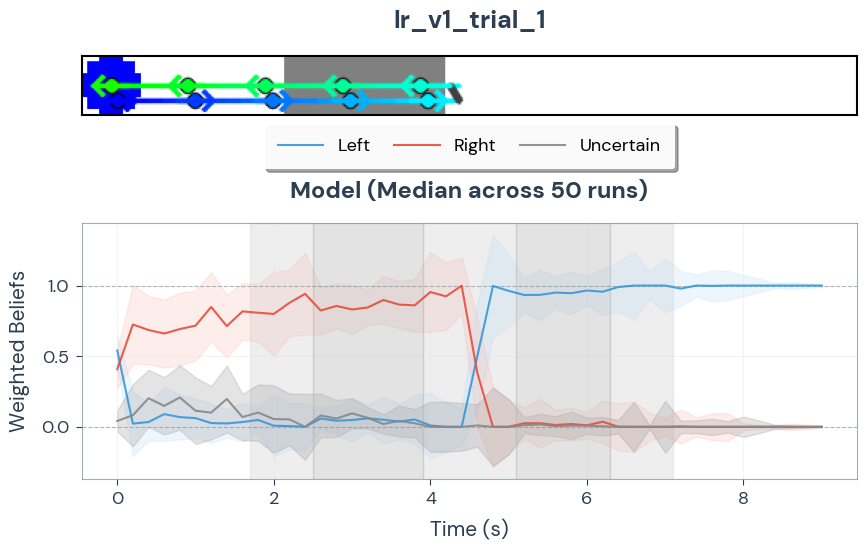

In [5]:
jtap_mice_beliefs = jtap_compute_beliefs(JTAPMICE_DATA)
jtap_run_idx = None
show_all_lines = False
show_std_band = True
jtap_plot_lr_lines(lr_beliefs = jtap_mice_beliefs, stimulus = jtap_stimulus, show = "model", include_baselines=False, remove_legend=False, show_std_band=show_std_band, jtap_run_idx = jtap_run_idx, include_start_frame=True, show_all_beliefs=show_all_lines, plot_stat = "median", include_stimulus=True)

In [18]:
import math
import os

import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import rerun as rr
from IPython.display import HTML as HTML_Display
from jax.scipy.special import logsumexp
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Arrow, Circle
from PIL import Image
from scipy.stats import vonmises
from tqdm import tqdm

from jtap_mice.utils import discrete_obs_to_rgb, slice_pt
from jtap_mice.inference import JTAPMiceData
from jtap_mice.evaluation import compute_weight_component_correlations, get_lr_raw_beliefs

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import jax.numpy as jnp
from IPython.display import HTML


def compute_lr_beliefs_directly(jtap_inference, jtap_run_idx, pred_len, num_frames, num_particles):
    pred_lr = jtap_inference.prediction.lr
    weights = jtap_inference.weight_data.final_weights
    arr_idx = jtap_run_idx if pred_lr.shape[0] > 1 else 0
    pred_lr = pred_lr[arr_idx]
    w = weights[arr_idx]
    offset = pred_len if pred_len is not None else jtap_inference.prediction.x.shape[1]
    idx = min(offset, pred_lr.shape[1]) - 1
    coded_lr_hits = np.array(pred_lr[:, idx, :])
    w = np.array(w)
    normalized_probs = np.exp(w - np.max(w, axis=1, keepdims=True))
    normalized_probs = normalized_probs / np.sum(normalized_probs, axis=1, keepdims=True)
    left_probs = np.sum((coded_lr_hits == 0) * normalized_probs, axis=1)
    right_probs = np.sum((coded_lr_hits == 1) * normalized_probs, axis=1)
    uncertain_probs = np.sum((coded_lr_hits == 2) * normalized_probs, axis=1)
    lr_belief_probs = np.stack([left_probs, right_probs, uncertain_probs], axis=1)
    return lr_belief_probs

def stack_tracking_and_predictions(tracking_x, prediction_x, sample_idx, pred_steps_use):
    """ 
    Returns array (n_frames, pred_steps_use+1, len(sample_idx))
    """
    tracking_x = np.array(tracking_x)  # (n_frames, n_particles)
    prediction_x = np.array(prediction_x)  # (n_frames, pred_steps, n_particles)
    n_frames = tracking_x.shape[0]
    n_sel_particles = len(sample_idx)

    tracking_x_sel = tracking_x[:, sample_idx]  # (n_frames, n_sel_particles)
    prediction_x_sel = prediction_x[:, :pred_steps_use, :][:, :, sample_idx]  # (n_frames, pred_steps_use, n_sel_particles)
    pred_x_full = np.concatenate([tracking_x_sel[:, None, :], prediction_x_sel], axis=1)  # (n_frames, pred_steps_use+1, n_sel_particles)
    return pred_x_full

def animate_jtap_mice_predictions(
    JTAPMICE_DATA, 
    pred_len=None, 
    jtap_run_idx=0, 
    image_scale=4, 
    max_particles_to_show=None, 
    stimulus=None,
    scn_dot_size=50, 
    pred_dot_size=50,
    line_thick_min=2.7,
    line_thick_max=10.5,
    use_tqdm=True,
    fps=10,
    return_html=True
):
    """
    Visualize particles, predictions, and left/right beliefs as an animated matplotlib figure.
    The prediction panel shows absolute timesteps with full trajectory history.
    """
    from tqdm.notebook import tqdm

    def _squeeze(arr):
        arr = np.array(arr)
        return arr[jtap_run_idx] if arr.shape[0] > 1 else arr[0]
    inf = JTAPMICE_DATA.inference

    scene_dim = JTAPMICE_DATA.params.inference_input.scene_dim
    scene_dim = np.array(scene_dim)
    if scene_dim.size > 0:
        Wscene = float(np.ravel(scene_dim)[0])
    else:
        Wscene = 1.0

    tracking_x = np.array(_squeeze(inf.tracking.x))
    tracking_y = np.array(_squeeze(inf.tracking.y)) if hasattr(inf.tracking, "y") else None
    weights = np.array(_squeeze(inf.weight_data.final_weights))
    prediction_x = np.array(_squeeze(inf.prediction.x))
    prediction_y = np.array(_squeeze(inf.prediction.y)) if hasattr(inf.prediction, "y") else None
    prediction_lr = np.array(_squeeze(inf.prediction.lr))

    num_frames, num_particles = tracking_x.shape
    pred_steps = prediction_x.shape[1]
    plot_pred_steps = pred_len if (pred_len is not None and pred_len <= pred_steps) else pred_steps
    plot_pred_steps_with_track = plot_pred_steps + 1

    # We'll determine the sample idx first.
    if (max_particles_to_show is not None) and (num_particles > max_particles_to_show):
        sample_idx = np.argsort(weights[0])[::-1][:max_particles_to_show]
    else:
        sample_idx = np.arange(num_particles)
    
    pred_x_full = stack_tracking_and_predictions(tracking_x, prediction_x, sample_idx, plot_pred_steps)
    # pred_x_full: (n_frames, plot_pred_steps+1, n_selected_particles)

    lr_belief_probs = compute_lr_beliefs_directly(
        JTAPMICE_DATA.inference,
        jtap_run_idx,
        plot_pred_steps,
        num_frames,
        num_particles
    )

    if stimulus is None:
        if hasattr(JTAPMICE_DATA, "stimulus"):
            stimulus = JTAPMICE_DATA.stimulus
        else:
            raise ValueError("Must provide the stimulus or ensure JTAPMICE_DATA.stimulus exists")
    if hasattr(stimulus, "rgb_video_highres"):
        rgb_vid = np.asarray(stimulus.rgb_video_highres)
    elif hasattr(stimulus, "rgb_video"):
        rgb_vid = np.asarray(stimulus.rgb_video)
    elif hasattr(stimulus, "discrete_obs"):
        rgb_vid = discrete_obs_to_rgb(stimulus.discrete_obs)
    else:
        raise ValueError("Could not find rgb frames in stimulus.")
    H, W = rgb_vid.shape[1:3]
    n_time = rgb_vid.shape[0]

    diameter = getattr(stimulus, "diameter")
    ball_radius_scene = diameter / 2.0

    # Get occlusion regions from stimulus
    occlusion_regions = None
    if hasattr(stimulus, "occlusion_regions"):
        occlusion_regions = np.array(stimulus.occlusion_regions)  # Shape: (N_OCC, 2)

    plt.rcParams.update({
        "font.size": 22,
        "axes.titlesize": 28,
        "axes.labelsize": 24,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "legend.fontsize": 20,
    })

    # Make figure taller to accommodate longer y-axis
    fig = plt.figure(
        figsize=(image_scale * 7, image_scale * 6),
        facecolor='w'
    )
    fig.suptitle(
        "Image-conditioned Sequential Monte Carlo for Tracking and Prediction",
        fontsize=32,
        fontweight='bold',
        y=0.99
    )

    gs = fig.add_gridspec(3, 4, height_ratios=[3, 2.5, 2], width_ratios=[4, 1, 0.01, 0.1])
    ax_pred = fig.add_subplot(gs[0:2, 0], facecolor='w')  # prediction (top left, takes 2 rows)
    ax_belief = fig.add_subplot(gs[0:2, 1], facecolor='w')  # LR bar (top right)
    ax_scene = fig.add_subplot(gs[2, 0], facecolor='w')    # Scene/image (bottom left)

    plt.subplots_adjust(left=0.16, right=0.99, top=0.90, bottom=0.01)

    ax_pred.set_title("Trajectory and Future Predictions")
    ax_scene.set_title("Ball center position (Black dots with alpha by SMC weights) over RGB image")
    ax_belief.set_title("LR Belief (prob)")

    import matplotlib.patches as mpatches

    # Create individual scatter plots for each particle to control alpha separately
    scn_dots = []
    for _ in range(len(sample_idx)):
        dot = ax_scene.scatter([], [], s=scn_dot_size, c='black', alpha=1.0, edgecolors='none', linewidths=0, zorder=3)
        scn_dots.append(dot)

    img_artist = ax_scene.imshow(
        np.zeros_like(rgb_vid[0]), origin="upper", animated=True, zorder=0, extent=(0, W, H, 0)
    )

    obs_border_rect = mpatches.Rectangle(
        (0, 0), W, H,
        linewidth=4, edgecolor='black', facecolor='none', zorder=2
    )
    ax_scene.add_patch(obs_border_rect)
    # Compute the "forbidden"/barrier boundaries in scene space:
    left_barrier_x = 0 + ball_radius_scene
    right_barrier_x = Wscene - ball_radius_scene
    # Add vertical dashed lines to ax_pred, to be updated later
    left_barrier_line = ax_pred.axvline(
        left_barrier_x, color='k', linestyle=':', linewidth=3, alpha=0.65, zorder=5, animated=True
    )
    right_barrier_line = ax_pred.axvline(
        right_barrier_x, color='k', linestyle=':', linewidth=3, alpha=0.65, zorder=5, animated=True
    )

    # Add occlusion regions to the prediction plot
    occlusion_patches = []
    if occlusion_regions is not None:
        for occ_region in occlusion_regions:
            occ_left, occ_size = occ_region
            # Full occlusion region (dark gray)
            full_occ_patch = mpatches.Rectangle(
                (occ_left, -0.5), occ_size, num_frames + plot_pred_steps,
                facecolor='gray', alpha=0.2, zorder=0, edgecolor='none'
            )
            ax_pred.add_patch(full_occ_patch)
            occlusion_patches.append(full_occ_patch)
            
            # Partial occlusion regions (light gray) - extend by ball radius on each side
            left_partial_left = occ_left - diameter
            if left_partial_left >= 0:  # Only add if within scene bounds
                left_partial_patch = mpatches.Rectangle(
                    (left_partial_left, -0.5), occ_size + (2 * diameter), num_frames + plot_pred_steps,
                    facecolor='lightgray', alpha=0.2, zorder=0, edgecolor='none'
                )
                ax_pred.add_patch(left_partial_patch)
                occlusion_patches.append(left_partial_patch)


    # Store historical positions and alphas for each particle
    historical_positions = {i: {'x': [], 'y': [], 'alphas': []} for i in range(len(sample_idx))}

    # Use orange lines for predictions instead of yellow - keep constant width
    lines = []
    for _ in range(len(sample_idx)):
        line, = ax_pred.plot([], [], lw=line_thick_max, color='#FFD700', alpha=0.8, zorder=2)  # dark yellow
        lines.append(line)
    
    # Create scatter plots for historical positions (one per particle)
    historical_dots = []
    for _ in range(len(sample_idx)):
        dots = ax_pred.scatter([], [], s=pred_dot_size, c='black', alpha=1.0, zorder=1, edgecolors='none', linewidths=0)
        historical_dots.append(dots)
    
    # Current position dots - create individual scatter plots for each particle
    pred_dots = []
    for _ in range(len(sample_idx)):
        dot = ax_pred.scatter([], [], s=pred_dot_size, c='black', alpha=1.0, zorder=3, edgecolors='none', linewidths=0)
        pred_dots.append(dot)

    bar_beliefs = ax_belief.bar(['Left', 'Right', 'Unc.'], [0, 0, 0], color=['#3399FF', '#FF9933', '#C0C0C0'])

    ax_pred.set_xlabel('X pos')
    ax_pred.set_ylabel('Time (absolute frame number)')

    ax_pred.set_xlim(0, Wscene)
    # Set y-axis to show absolute time from 0 to num_frames + plot_pred_steps
    max_y = num_frames + plot_pred_steps
    ax_pred.set_ylim(-0.5, max_y - 0.5)
    ax_pred.set_xticks(np.arange(0, int(np.ceil(Wscene)) + 1, 1))
    ax_pred.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Set y-axis ticks for absolute time
    y_tick_step = max(1, max_y // 20)  # Adjust tick density based on total frames
    y_tick_locs = np.arange(0, max_y, y_tick_step)
    ax_pred.set_yticks(y_tick_locs)
    ax_pred.set_yticklabels([f"{int(yy)}" for yy in y_tick_locs])
    ax_pred.grid(True, linestyle='--', alpha=0.3)

    ax_scene.set_axis_off()
    ax_scene.set_xlim(0, W)
    ax_scene.set_ylim(H, 0)
    ax_belief.set_ylim(0, 1.01)
    ax_belief.set_ylabel('Prob')
    ax_belief.set_xticks([0, 1, 2])
    ax_belief.set_xticklabels(['Left', 'Right', 'Unknown'])
    for spine in ["top", "right"]:
        ax_belief.spines[spine].set_visible(False)

    def normalize_weights(w):
        w = np.array(w)
        m = np.max(w)
        if m == 0:
            return np.ones_like(w)
        w = w - np.max(w)
        w = np.exp(w)
        return w / np.sum(w)

    def compute_alphas(weights, min_alpha=0.0, max_alpha=1.0):
        wnorm = normalize_weights(weights)
        alphas = min_alpha + (max_alpha - min_alpha) * wnorm
        return alphas

    anim_progress = {'bar': None, 'last_frame': -1}

    def find_crossing(x_vals, y_vals, barrier_x, direction):
        """
        Find the segment where the prediction crosses the barrier (left or right).
        Returns the index of first crossing, and the interpolated (x, y) of the crossing point.
        """
        xs = np.array(x_vals)
        ys = np.array(y_vals)
        for i in range(len(xs)-1):
            if direction == "left":
                if xs[i] > barrier_x and xs[i+1] <= barrier_x:
                    # interpolate crossing point
                    dx = xs[i+1] - xs[i]
                    dy = ys[i+1] - ys[i]
                    if dx == 0:
                        alpha = 0
                    else:
                        alpha = (barrier_x - xs[i]) / dx
                    cross_y = ys[i] + alpha * dy
                    return i+1, barrier_x, cross_y
            elif direction == "right":
                if xs[i] < barrier_x and xs[i+1] >= barrier_x:
                    dx = xs[i+1] - xs[i]
                    dy = ys[i+1] - ys[i]
                    if dx == 0:
                        alpha = 0
                    else:
                        alpha = (barrier_x - xs[i]) / dx
                    cross_y = ys[i] + alpha * dy
                    return i+1, barrier_x, cross_y
        return None

    def animate(t):
        if use_tqdm:
            if anim_progress['bar'] is None:
                anim_progress['bar'] = tqdm(total=num_frames, desc="Rendering frames", leave=True)
                anim_progress['last_frame'] = -1
            if t > anim_progress['last_frame']:
                anim_progress['bar'].n = t + 1
                anim_progress['bar'].refresh()
                anim_progress['last_frame'] = t
            if (t + 1) == num_frames:
                anim_progress['bar'].close()

        img = rgb_vid[t]
        img_artist.set_data(img)
        img_artist.set_extent((0, W, H, 0))
        tx = tracking_x[t]
        tw = weights[t]
        s_idx = np.array(sample_idx)
        tx_samp = tx[s_idx]
        tw_samp = tw[s_idx]
        tx_samp_center = tx_samp + ball_radius_scene
        x_pix_center = tx_samp_center * (W / Wscene)
        y_pix = np.ones_like(x_pix_center) * (H / 2)

        alphas_scn = compute_alphas(tw_samp)
        for i, dot in enumerate(scn_dots):
            if i < len(x_pix_center):
                dot.set_offsets([[x_pix_center[i], y_pix[i]]])
                dot.set_alpha(alphas_scn[i])
            else:
                dot.set_offsets(np.empty((0, 2)))

        # Compute current dot alphas for pred_dots
        current_dot_alphas = compute_alphas(tw_samp)

        # Update historical positions for each particle - store the alpha from this timestep
        for p_idx in range(len(s_idx)):
            historical_positions[p_idx]['x'].append(tx_samp_center[p_idx])
            historical_positions[p_idx]['y'].append(t)
            historical_positions[p_idx]['alphas'].append(current_dot_alphas[p_idx])

        # Update historical dots for each particle
        for p_idx in range(len(s_idx)):
            if len(historical_positions[p_idx]['x']) > 1:  # Only show history if we have more than current point
                hist_x = historical_positions[p_idx]['x'][:-1]  # All but current
                hist_y = historical_positions[p_idx]['y'][:-1]  # All but current
                hist_alphas = historical_positions[p_idx]['alphas'][:-1]  # All but current - use stored alphas
                if len(hist_x) > 0:
                    # For historical dots, we'll use the average alpha or the last alpha
                    avg_alpha = np.mean(hist_alphas) if len(hist_alphas) > 0 else 0.5
                    historical_dots[p_idx].set_offsets(np.stack([hist_x, hist_y], axis=1))
                    historical_dots[p_idx].set_alpha(avg_alpha)
                else:
                    historical_dots[p_idx].set_offsets(np.empty((0, 2)))
            else:
                historical_dots[p_idx].set_offsets(np.empty((0, 2)))

        # Now assemble predictions starting from current time t
        xs_pred_t = pred_x_full[t] + ball_radius_scene  # (plot_pred_steps_with_track, n_sel_particles)
        # Y coordinates are now absolute time: current time t, then t+1, t+2, etc.
        ys_pred_t = (t + np.arange(plot_pred_steps_with_track))[:, None] * np.ones((1, len(s_idx)))  # (plot_pred_steps_with_track, n_sel_particles)

        # For the current position scatter (just current time t)
        for p_idx in range(len(s_idx)):
            pred_dots[p_idx].set_offsets([[xs_pred_t[0, p_idx], t]])
            pred_dots[p_idx].set_alpha(current_dot_alphas[p_idx])

        line_alphas = compute_alphas(tw_samp)

        # For each displayed particle, mask its predictions if predicted ball *center* has reached a radius away from either barrier
        for li, p_idx in enumerate(range(len(s_idx))):
            xs_particle = xs_pred_t[:, li]  # scene x-coords for all prediction steps (center of ball)
            ys_particle = ys_pred_t[:, li]  # absolute time steps

            # We start with all points
            idxs_to_draw = np.arange(len(xs_particle))

            # We'll treat exclusion as: stop showing after prediction *reaches* or exceeds left_barrier_x or right_barrier_x
            # Find if we cross the left or right barrier - interpolate if so
            left_cross = find_crossing(xs_particle, ys_particle, left_barrier_x, direction="left")
            right_cross = find_crossing(xs_particle, ys_particle, right_barrier_x, direction="right")

            # Decide which barrier is hit first, if any
            barrier_cut_idx = None
            barrier_x = None
            barrier_y = None
            if left_cross and right_cross:
                # Take the smaller index (whichever occurs first in the prediction steps)
                if left_cross[0] <= right_cross[0]:
                    barrier_cut_idx = left_cross[0]
                    barrier_x = left_cross[1]
                    barrier_y = left_cross[2]
                else:
                    barrier_cut_idx = right_cross[0]
                    barrier_x = right_cross[1]
                    barrier_y = right_cross[2]
            elif left_cross:
                barrier_cut_idx = left_cross[0]
                barrier_x = left_cross[1]
                barrier_y = left_cross[2]
            elif right_cross:
                barrier_cut_idx = right_cross[0]
                barrier_x = right_cross[1]
                barrier_y = right_cross[2]

            xs_draw = xs_particle
            ys_draw = ys_particle

            if barrier_cut_idx is not None:
                # Include up to step before crossing, and then add the crossing point
                xs_draw = np.concatenate([xs_particle[:barrier_cut_idx], [barrier_x]])
                ys_draw = np.concatenate([ys_particle[:barrier_cut_idx], [barrier_y]])
                mask = np.zeros_like(xs_particle, dtype=bool)
                mask[:barrier_cut_idx] = True
                mask[barrier_cut_idx] = True
            else:
                mask = np.ones_like(xs_particle, dtype=bool)
            
            # Additionally, if you want to combine with old 'lr' boundary masking, do so as well:
            lrs = prediction_lr[t, :plot_pred_steps, s_idx[li]]
            # But barrier check is strict, so we only mask if we hit barrier OR LR label
            hit_lr_idx = None
            hits_lr = np.where((lrs == 0) | (lrs == 1))[0]
            # If double-mask, ensure we don't show more than either
            if len(hits_lr) > 0:
                hit_lr_idx = hits_lr[0]
                lr_cut = hit_lr_idx + 2  # original logic
                # Combine masks: shortest length
                if barrier_cut_idx is not None:
                    draw_len = min(lr_cut, len(xs_draw))
                    xs_draw = xs_draw[:draw_len]
                    ys_draw = ys_draw[:draw_len]
                else:
                    mask[lr_cut:] = False
                    xs_draw = xs_draw[mask]
                    ys_draw = ys_draw[mask]

            lines[li].set_data(xs_draw, ys_draw)
            lines[li].set_alpha(line_alphas[li])

        left_p, right_p, unc_p = lr_belief_probs[t]
        for i, bar in enumerate(bar_beliefs):
            bar.set_height([left_p, right_p, unc_p][i])
            if i == 0:
                bar.set_color("#0055CC" if left_p > right_p else "#3399FF")
            elif i == 1:
                bar.set_color("#FFA416" if right_p > left_p else "#FF9933")
            else:
                bar.set_color("#C0C0C0")
        ax_belief.set_ylim(0, 1.01)
        ax_belief.set_title("LR belief:\nL={:.2f}, R={:.2f}, U={:.2f}".format(left_p, right_p, unc_p), fontsize=26)
        for ax in [ax_pred, ax_scene]:
            ax.set_title(ax.get_title().split('\n')[0] + f"\nframe {t + 1}/{num_frames}", fontsize=26)

        return [img_artist] + scn_dots + lines + pred_dots + list(bar_beliefs) + [obs_border_rect, left_barrier_line, right_barrier_line] + historical_dots + occlusion_patches

    anim = animation.FuncAnimation(
        fig, animate, frames=num_frames, interval=(1000/fps), blit=True, repeat=True
    )
    plt.close()
    
    if return_html:
        return HTML_Display(anim.to_html5_video())
    else:
        return HTML_Display(anim.to_jshtml())


In [19]:
animate_jtap_mice_predictions(
    JTAPMICE_DATA, 
    jtap_run_idx=0,
    scn_dot_size=200, 
    pred_dot_size=200,
    line_thick_min=10,
    line_thick_max=10,
    use_tqdm=True,
    fps=10,
    return_html=True
)

Rendering frames:   0%|          | 0/46 [00:00<?, ?it/s]